# Dataset Exploration

In [82]:
"""Dataset Exploration

The objective here is to retrieve information on the datasets. We are interested in answering the following questions:
    * How many datasets are there?
    * What types? 
    * What organisms?
    * How recent?
    * Is there overlap with iLINCS datasets?


Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Dataset Exploration

"""

# 1. Imports, Variables and Functions
# imports
import numpy as np, pandas as pd, os, sys, re, json, pickle, time, datetime, random
import logging
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
import re
import time
from Bio import Entrez
from multiprocessing import Pool
from http.client import IncompleteRead
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import random
import multiprocessing
from tqdm import tqdm

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
filter_criteria = lambda s: (s["libraryid"] == "LIB_1")
base_url = "http://www.ilincs.org/api"
output_path_figures = os.path.join("..", "results", "figures", "DiSignAtlas")

# functions


def get_date_from_geo(geo):
    """Get Date From GEO

    Function to retrieve date from GEO accesion code.

    Args:
        geo (str): GEO accession code.

    Returns:
        date (str): Date in fromat day month, year.
    """

    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo}"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        submission_date = None
        for tr in soup.find_all("tr", bgcolor="#eeeeee"):
            tds = tr.find_all("td")
            if tds and len(tds) >= 2 and "Submission date" in tds[0].get_text():
                submission_date = tds[1].get_text().strip()
                break
        return submission_date
    else:
        return None


def process_id(iLINCS_gds_id):
    Entrez.email = "your.email@example.com"
    attempts = 0
    max_attempts = 5
    sleep_time = 1  # seconds

    while attempts < max_attempts:
        try:
            # Search for the GDS database
            handle = Entrez.esearch(db="gds", term=iLINCS_gds_id)
            record = Entrez.read(handle)
            handle.close()

            if not record["IdList"]:
                return iLINCS_gds_id, "No ID found in record"

            record_id = record["IdList"][0]

            # Fetch the specific record in XML format
            handle = Entrez.efetch(db="gds", id=record_id, retmode="xml")
            data = handle.read()
            handle.close()

            match = re.search(r"Accession: GSE\d+", data)

            if match:
                accession_code = match.group(0).split("Accession: ")[1]
                return iLINCS_gds_id, accession_code
            else:
                return iLINCS_gds_id, "No accession code found."

        except IncompleteRead:
            attempts += 1
            time.sleep(sleep_time)
        except Exception as e:
            return iLINCS_gds_id, f"Error: {str(e)}"

    return iLINCS_gds_id, "Failed after multiple attempts"


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def process_dataset(dataset_id):
    # retrieve metadata from iLINCS for specific datasetid
    metadata = fetch_dataset_metadata(dataset_id)
    gds_id = metadata["SourceID"]
    return gds_id


# 2. Load Data
df_data_info = pd.read_csv(data_info_path)


# 3. Dataset Exploration

### * How many datasets are there?

In [9]:
# check if we have these datasets in our files
not_found_datasets = list()
for dsaid in df_data_info["dsaid"].unique():
    # check microarray data path
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )
    if not os.path.exists(data_path):
        # check single cell data path
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )
        if not os.path.exists(data_path):
            not_found_datasets.append(dsaid)

logging.info(
    f"Nº of datasets not found: {len(not_found_datasets)}/{len(df_data_info['dsaid'].unique())}"
)

2024-02-03 09:26:56,745 - INFO - Nº of datasets not found: 0/10306


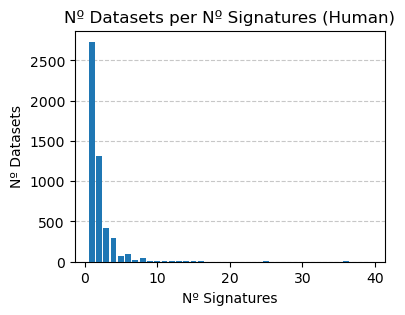

In [90]:
data = Counter(list(df_data_info["accession"].value_counts()))

# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Define figure size
plt.figure(figsize=(4, 3))

# Creating the bar plot
plt.bar(labels, values, zorder=3)

# Set y scale to logarithmic
# plt.yscale('log')

# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.xlabel("Nº Signatures")
plt.ylabel("Nº Datasets")
plt.title("Nº Datasets per Nº Signatures (Human)")


# Show the plot
plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.n_signatures_per_dataset.png"),
    dpi=300,
    bbox_inches="tight",
)

### * How many signatures per disease?

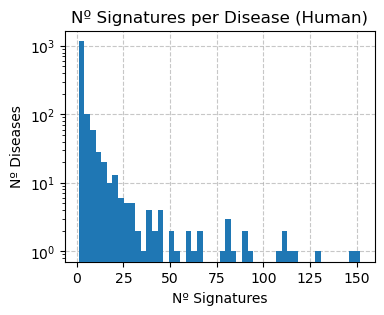

In [89]:
data = list(
    Counter(
        df_data_info[df_data_info["organism"] == "Homo sapiens"]["disease"].to_list()
    ).values()
)

# Define figure size
plt.figure(figsize=(4, 3))

# Creating the bar plot
plt.hist(data, bins=50, zorder=3)

# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)
plt.grid(axis="x", linestyle="--", alpha=0.7, zorder=-1)

# change to logarithmic scale
plt.yscale("log")

# Adding titles and labels
plt.xlabel("Nº Signatures")
plt.ylabel("Nº Diseases")
plt.title("Nº Signatures per Disease (Human)")


# Show the plot
plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.n_signatures_per_disease.png"),
    dpi=300,
    bbox_inches="tight",
)

### * What types?


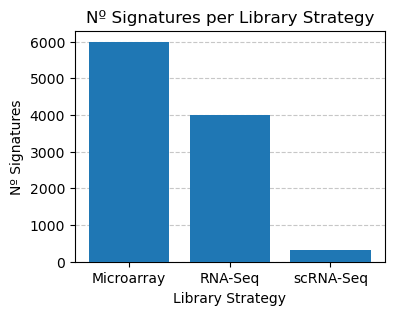

In [11]:
data = dict(df_data_info["library_strategy"].value_counts()[:3])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Define figure size
plt.figure(figsize=(4, 3))

# Creating the bar plot
plt.bar(labels, values, zorder=3)

# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.xlabel("Library Strategy")
plt.ylabel("Nº Signatures")
plt.title("Nº Signatures per Library Strategy")


# Show the plot
plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.type_of_data.png"),
    dpi=300,
    bbox_inches="tight",
)

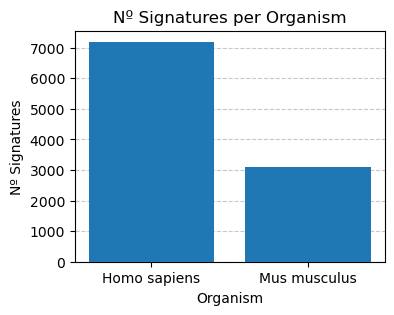

In [12]:
data = dict(df_data_info["organism"].value_counts()[:2])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Define figure size
plt.figure(figsize=(4, 3))

# Creating the bar plot
plt.bar(labels, values, zorder=3)

# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.xlabel("Organism")
plt.ylabel("Nº Signatures")
plt.title("Nº Signatures per Organism")

plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.organisms.png"),
    dpi=300,
    bbox_inches="tight",
)

### How many signatures per gene are there in the dataset?


In [151]:
# get all entrez mouse ids
def get_mouse_entrez_ids():
    """Get Mouse Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID"])
    df_mouse = df[df["#tax_id"] == 10090]
    logging.info(f"Nº of human genes: {len(df_mouse)}")
    return df_mouse["GeneID"].to_list()


# get all entrez human ids
def get_human_entrez_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID"])
    df_human = df[df["#tax_id"] == 9606]
    return df_human["GeneID"].to_list()

In [153]:
entrez_mouse_ids = get_mouse_entrez_ids()
entrez_human_ids = get_human_entrez_ids()

2024-02-05 15:32:20,799 - INFO - Nº of human genes: 112319


In [123]:
test_set = {1, 2, 3, 4}

In [157]:
len(test_set & set(entrez_mouse_ids))

0

In [229]:
def is_mouse_genes(gene_list, entrez_mouse_ids):
    """Is Human Genes
    Args:
        gene_list (list): list of genes
        entrez_mouse_ids (list): list of mouse entrez ids
    Returns:
        bool: True if any human is mouse
    """
    if len(set(gene_list) & set(entrez_mouse_ids)) > 100:
        return True, True

    elif len(set(gene_list) & set(entrez_mouse_ids)) > 0:
        return True, False

    else:
        return False, False


def is_human_genes(gene_list, entrez_human_ids):
    """Is Human Genes
    Args:
        gene_list (list): list of genes
        entrez_human_ids (list): list of human entrez ids
    Returns:
        bool: True if less than 100 genes are not human
        bool: True if all genes are human
    """
    if len(set(gene_list) - set(entrez_human_ids)) == 0:
        return True, True

    elif len(set(gene_list) - set(entrez_human_ids)) < 100:
        return True, False

    else:
        return False, False

In [100]:
# Load the all genes per (human) signature


def get_DiSignAtlas_gene_ids(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path, sep="\t")
        return df["GeneID"].tolist()
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path, sep=",")
        return df["geneid"].tolist()


def get_DiSignAtlas_gene_ids(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download.individual_downloads", dsaid
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path, sep="\t")
        return df["GeneID"].tolist()
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path, sep=",")
        return df["geneid"].tolist()

In [108]:
df_data_info_filtered = df_data_info[
    (df_data_info["organism"] == "Homo sapiens")
    & (
        (df_data_info["library_strategy"] == "Microarray")
        | (df_data_info["library_strategy"] == "RNA-Seq")
    )
]

df_data_info_filtered.shape

(7004, 12)

In [110]:
from tqdm.contrib.concurrent import process_map


human_dsaids = df_data_info_filtered["dsaid"].to_list()
human_library = df_data_info_filtered["library_strategy"].to_list()

human_dsaid_genes = list()
# for dsaid in tqdm(human_dsaids):
#     genes_ids = get_DiSignAtlas_gene_ids(dsaid)
#     human_dsaid_genes.append(list(set(genes_ids)))

results = process_map(
    get_DiSignAtlas_gene_ids, human_dsaids, max_workers=8, chunksize=1
)

/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 7004/7004 [03:06<00:00, 37.50it/s] 


In [112]:
human_dsaid_genes = results

In [186]:
mouse_dsaid_very_true = list()
mouse_dsaid_true = list()
mouse_dsaid_false = list()
for dsaid, genes in tqdm(zip(human_dsaids, human_dsaid_genes)):
    any_mouse_genes, a_lot = is_mouse_genes(
        gene_list=genes, entrez_mouse_ids=entrez_mouse_ids
    )
    if any_mouse_genes & a_lot:
        mouse_dsaid_very_true.append(dsaid)
    elif any_mouse_genes:
        mouse_dsaid_true.append(dsaid)
    else:
        mouse_dsaid_false.append(dsaid)

7004it [00:42, 165.50it/s]


In [230]:
human_dsaid_very_true = list()
human_dsaid_true = list()
human_dsaid_false = list()
for dsaid, genes in tqdm(zip(human_dsaids, human_dsaid_genes)):
    most_human, all_human = is_human_genes(
        gene_list=genes, entrez_human_ids=entrez_human_ids
    )
    if most_human & all_human:
        human_dsaid_very_true.append(dsaid)
    elif most_human:
        human_dsaid_true.append(dsaid)
    else:
        human_dsaid_false.append(dsaid)

7004it [01:19, 87.88it/s] 


In [232]:
logging.info(f"Nº of dsaids w/ all human genes {len(human_dsaid_very_true)}")
logging.info(f"Nº of dsaids w/ <100 non-human genes {len(human_dsaid_true)}")
logging.info(f"Nº of dsaids w/ a lot of non-human genes {len(human_dsaid_false)}")

2024-02-05 16:37:57,809 - INFO - Nº of dsaids w/ all human genes 888
2024-02-05 16:37:57,809 - INFO - Nº of dsaids w/ <100 non-human genes 4266
2024-02-05 16:37:57,810 - INFO - Nº of dsaids w/ a lot of non-human genes 1850


In [226]:
mouse_dsaid_very_true

['DSA00478',
 'DSA00479',
 'DSA05353',
 'DSA05792',
 'DSA05793',
 'DSA05800',
 'DSA05820']

In [192]:
found_mouse_genes = set()
for dsaid in mouse_dsaid_true:
    found = set(dsaid_2_genes.get(dsaid)) & set(entrez_mouse_ids)
    found_mouse_genes.update(found)

In [220]:
set(dsaid_2_genes.get("DSA05353")) & set(entrez_mouse_ids))

In [236]:
set(dsaid_2_genes.get("DSA00128")) - set(entrez_human_ids)

{2575,
 9142,
 9220,
 10896,
 23285,
 25784,
 25787,
 26148,
 26222,
 28994,
 29013,
 29044,
 54094,
 54748,
 55354,
 55387,
 55412,
 55415,
 55448,
 55460,
 55478,
 55547,
 57051,
 57235,
 57242,
 57399,
 57796,
 79860,
 79904,
 80761,
 83935,
 84237,
 84757,
 84786,
 84843,
 84849,
 84953,
 85367,
 85368,
 85375,
 92973,
 93444,
 114299,
 117153,
 117852,
 129790,
 140849,
 142937,
 145678,
 145945,
 147791,
 149351,
 149650,
 149703,
 150005,
 151657,
 153546,
 153577,
 153682,
 157562,
 157740,
 157860,
 157931,
 158263,
 158295,
 158402,
 158696,
 170063,
 200609,
 200830,
 202025,
 219688,
 219690,
 221272,
 221814,
 243469,
 246318,
 246734,
 253805,
 254057,
 255177,
 257152,
 266621,
 266671,
 266918,
 280665,
 283070,
 283075,
 283112,
 283218,
 283357,
 283454,
 283482,
 283484,
 283485,
 283516,
 283588,
 283674,
 283737,
 283745,
 283861,
 284014,
 284083,
 284219,
 284242,
 284263,
 284373,
 284513,
 284669,
 284702,
 284808,
 284926,
 285147,
 285178,
 285181,
 285300,
 

In [245]:
set_non_human_genes = set()

for dsaid in tqdm(human_dsaid_false):
    found = set(dsaid_2_genes.get(dsaid)) - set(entrez_human_ids)
    if len(found & set(entrez_mouse_ids)) < 100:
        set_non_human_genes.update(found)

  0%|          | 0/1850 [00:00<?, ?it/s]

100%|██████████| 1850/1850 [00:15<00:00, 116.91it/s]


In [243]:
len(set_non_human_genes)

14212

In [248]:
set_non_human_genes

{131086,
 644784,
 196707,
 196752,
 180,
 164022,
 188,
 195,
 164036,
 100129286,
 244,
 196994,
 197049,
 221550,
 221552,
 100129360,
 131691,
 100270710,
 692,
 197317,
 197319,
 197336,
 197379,
 197387,
 492304,
 872,
 876,
 131963,
 934,
 985,
 132235,
 645014,
 165057,
 1231,
 100500805,
 105372417,
 132706,
 132707,
 100271840,
 1764,
 1772,
 132870,
 1985,
 285009,
 362495,
 100272148,
 133185,
 100272216,
 221876,
 645221,
 2291,
 494024,
 2552,
 100507496,
 2575,
 2586,
 133926,
 723788,
 723805,
 133993,
 2945,
 2955,
 3022,
 199680,
 645389,
 645392,
 199714,
 199725,
 199775,
 199858,
 3262,
 199897,
 199906,
 199923,
 3331,
 3333,
 199986,
 199989,
 101059906,
 200019,
 100240726,
 101059954,
 645462,
 200058,
 134541,
 645469,
 200095,
 200107,
 200169,
 3599,
 200213,
 167454,
 200226,
 200230,
 3637,
 3668,
 200292,
 200317,
 200321,
 101060256,
 200383,
 3807,
 200475,
 200493,
 101060400,
 200515,
 101060424,
 101060458,
 26836,
 101060510,
 200609,
 200624,
 2006

In [250]:
from Bio import Entrez

# Always provide your email to NCBI when using E-utilities
Entrez.email = "your_email@example.com"


def get_updated_id(old_id):
    try:
        handle = Entrez.elink(dbfrom="gene", id=old_id, linkname="gene_gene")
        records = Entrez.read(handle)
        handle.close()

        # Check if there's a link to a new ID
        if records[0]["LinkSetDb"]:
            new_ids = records[0]["LinkSetDb"][0]["Link"]
            # For simplicity, we'll just take the first new ID if there are multiple
            new_id = new_ids[0]["Id"]
            print(f"Old ID {old_id} maps to new ID {new_id}")
            return new_id
        else:
            print(f"No direct update found for ID {old_id}")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Example usage
old_gene_id = "244"  # Replace with an actual old gene ID
get_updated_id(old_gene_id)

No direct update found for ID 244


In [ ]:
def get_gene_info(bryan):
    handle = Entrez.efetch(db="gene", id=bryan, retmode="xml")
    record = Entrez.read(handle)
    handle.close()
    return record


if ()

In [255]:
handle = Entrez.elink(dbfrom="gene", id=9, linkname="gene_gene")

In [262]:
search_handle = Entrez.esearch(
    db="gene", term=f"{9}[Gene ID] AND Homo sapiens[Organism]"
)
Entrez.read(search_handle)["IdList"]

[]

In [270]:
handle = Entrez.efetch(db="gene", id=244, retmode="xml")

In [271]:
Entrez.read(handle)

[{'Entrezgene_track-info': {'Gene-track': {'Gene-track_geneid': '244', 'Gene-track_status': StringElement('1', attributes={'value': 'secondary'}), 'Gene-track_current-id': [{'Dbtag_db': 'LocusID', 'Dbtag_tag': {'Object-id': {'Object-id_id': '728113'}}}, {'Dbtag_db': 'GeneID', 'Dbtag_tag': {'Object-id': {'Object-id_id': '728113'}}}], 'Gene-track_create-date': {'Date': {'Date_std': {'Date-std': {'Date-std_year': '1999', 'Date-std_month': '9', 'Date-std_day': '17'}}}}, 'Gene-track_update-date': {'Date': {'Date_std': {'Date-std': {'Date-std_year': '2019', 'Date-std_month': '2', 'Date-std_day': '13', 'Date-std_hour': '1', 'Date-std_minute': '38', 'Date-std_second': '0'}}}}, 'Gene-track_discontinue-date': {'Date': {'Date_std': {'Date-std': {'Date-std_year': '2014', 'Date-std_month': '4', 'Date-std_day': '9', 'Date-std_hour': '6', 'Date-std_minute': '9', 'Date-std_second': '0'}}}}}}, 'Entrezgene_type': StringElement('6', attributes={'value': 'protein-coding'}), 'Entrezgene_source': {'BioSourc

In [228]:
if len(set(dsaid_2_genes.get("DSA00042")) - set(entrez_human_ids)) < 100:
    print("poo")

poo


In [200]:
len(set(dsaid_2_genes.get("DSA05353")))

6662

In [194]:
found_mouse_genes

{12263,
 12266,
 12274,
 14058,
 14066,
 14067,
 14068,
 14069,
 14071,
 14955,
 19069,
 20997,
 58992,
 72284,
 73205,
 109821,
 109828,
 243469,
 386753,
 723792}

In [169]:
dsaid_2_genes = dict(zip(human_dsaids, human_dsaid_genes))

In [184]:
len(set(dsaid_2_genes["DSA00478"]) & set(entrez_mouse_ids))

15264

In [174]:
set(dsaid_2_genes["DSA00128"]) & set(entrez_mouse_ids)

{243469, 386753}

In [144]:
set(human_dsaid_genes[0]).intersection(set(entrez_human_ids))

{1,
 2,
 3,
 131076,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 131096,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 131118,
 47,
 48,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 70,
 71,
 72,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 97,
 98,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 24,
 123,
 125,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 136,
 140,
 141,
 142,
 143,
 146,
 147,
 148,
 150,
 151,
 152,
 153,
 154,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 172,
 174,
 175,
 176,
 178,
 181,
 182,
 183,
 185,
 186,
 187,
 189,
 190,
 191,
 196,
 197,
 199,
 202,
 203,
 204,
 205,
 207,
 208,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 229,
 230,
 231,
 238,
 239,
 240,
 241,
 242,
 245,
 246,
 247,
 248,
 249,
 257,
 258,
 259,
 262,
 267,
 268,


In [145]:
set(human_dsaid_genes[0]) - (set(entrez_human_ids))

{100505728,
 100507415,
 101927861,
 101928762,
 101929506,
 102477328,
 105369855,
 105370956,
 105371070,
 105371366,
 105373366,
 105375403,
 105375839,
 105376108,
 105377151,
 105377272,
 105378114,
 105378963,
 105378973,
 105379365,
 105379611,
 107984088,
 107984114,
 107984203,
 107984428,
 107984525,
 107985284,
 107985428,
 107985564,
 107986114,
 107986155,
 107986517,
 107986730,
 112267915,
 112268007,
 112268186,
 121009650}

In [113]:
[
    dsaid
    for dsaid, sublist in zip(human_dsaids, human_dsaid_genes)
    if 108167357 in sublist
]

['DSA00478']

In [97]:
dsaid = "DSA00478"
data_path = os.path.join(
    "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
)

if os.path.exists(data_path):
    df = pd.read_csv(data_path, sep="\t")

In [98]:
df

,GeneID,AveExpr_Control,AveExpr_Case,MidExpr_Control,MidExpr_Case,Log2FC,PValue,AdjPValue,regulation,neglog10p
0,404711,0.000000,397.700810,0.000000,0.0,24.940825,NaN,NaN,nosig,NaN
1,16016,0.000000,267.217077,0.000000,0.0,24.651188,NaN,NaN,nosig,NaN
2,667865,0.000000,1014.977128,0.000000,0.0,24.352788,NaN,NaN,nosig,NaN
3,17224,0.000000,103.270259,0.000000,0.0,23.272091,NaN,NaN,nosig,NaN
4,546213,0.000000,312.943370,0.000000,0.0,23.163956,NaN,NaN,nosig,NaN
...,...,...,...,...,...,...,...,...,...,...
15272,18054,723.068609,1.885361,137.368481,0.0,-8.267472,NaN,NaN,nosig,NaN
15273,233056,4.425628,0.000000,4.524502,0.0,-8.854803,2.246133e-08,9.066345e-07,down,7.648564
15274,665574,14.895606,0.000000,8.503613,0.0,-8.883283,1.346342e-08,5.778843e-07,down,7.870844
15275,271127,6.556650,0.000000,2.618005,0.0,-8.903719,4.027586e-08,1.539068e-06,down,7.394955


In [96]:
df_data_info[df_data_info["dsaid"] == "DSA00478"]

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition
477,DSA00478,GSE106775,GPL19057,1000,Glioblastoma,C0017636,NaN,GEO,RNA-Seq,Homo sapiens,3|3,DO:A malignant astrocytoma characterized by th...


In [33]:
human_dsaid_genes_all = [gene for sublist in human_dsaid_genes for gene in sublist]
data = Counter(human_dsaid_genes_all)

# Sort these values in ascending order
sorted_data = sorted(data.items(), key=lambda x: x[1])

In [71]:
test_genes = list()

for genes_ids, library in zip(human_dsaid_genes, human_library):
    if (library != "scRNA-Seq") & (library != "snRNA-Seq"):
        test_genes.extend(genes_ids)

In [78]:
n_genes_per_signature_all = [len(sublist) for sublist in human_dsaid_genes]
n_genes_per_signature_microarray = [
    len(sublist)
    for sublist, library in zip(human_dsaid_genes, human_library)
    if library == "Microarray"
]
n_genes_per_signature_RNA_Seq = [
    len(sublist)
    for sublist, library in zip(human_dsaid_genes, human_library)
    if library == "RNA-Seq"
]

In [92]:
genes

(28314,
 652873,
 327799,
 327814,
 108167357,
 98736,
 65971,
 98741,
 108167726,
 328258,
 623279,
 108167931,
 66338,
 328660,
 108168152,
 100041697,
 99439,
 66797,
 102466817,
 328967,
 328971,
 99663,
 329078,
 108168714,
 329278,
 67149,
 108168809,
 624245,
 329387,
 67293,
 100042484,
 100042499,
 100042568,
 231470,
 329797,
 329844,
 102631555,
 329872,
 67737,
 231603,
 67792,
 624855,
 231858,
 625121,
 100043308,
 102631981,
 232065,
 68239,
 330502,
 68396,
 102632272,
 330820,
 724063,
 100502653,
 101544,
 330941,
 100502736,
 68874,
 100502842,
 100502874,
 68955,
 100502950,
 102632947,
 69121,
 100503117,
 102633109,
 69297,
 102075,
 69324,
 102633213,
 69376,
 69397,
 331547,
 100503427,
 626583,
 69540,
 692169,
 102633437,
 100503545,
 102633478,
 100306952,
 69642,
 100306954,
 69659,
 102633516,
 100503620,
 626834,
 69864,
 100503802,
 626942,
 100503816,
 332175,
 100503962,
 100503965,
 100503970,
 102633939,
 102633942,
 627171,
 791076,
 627324,
 70319,


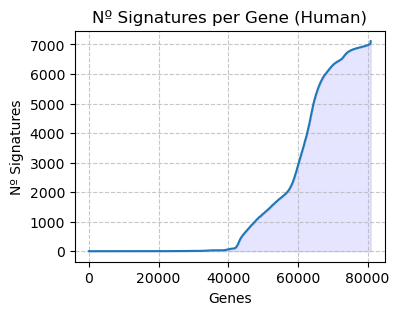

In [87]:
# Prepare data for plotting
genes, values = zip(*sorted_data)  # Unzipping the sorted data into two lists
index_genes = list(range(len(genes)))

plt.figure(figsize=(4, 3))
plt.plot(index_genes, values, marker="", markersize=0, linewidth=1.5)


# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)
plt.grid(axis="x", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.title("Nº Signatures per Gene (Human)")
plt.xlabel("Genes")
plt.ylabel("Nº Signatures")

# Color the area under the line without the 'step' and 'interpolate' parameters
plt.fill_between(index_genes, values, alpha=0.1, color="blue")

plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.n_signatures_per_gene.png"),
    dpi=300,
    bbox_inches="tight",
)

In [84]:
n_genes_per_signature_all = [len(sublist) for sublist in human_dsaid_genes]
n_genes_per_signature_microarray = [
    len(sublist)
    for sublist, library in zip(human_dsaid_genes, human_library)
    if library == "Microarray"
]
n_genes_per_signature_RNA_Seq = [
    len(sublist)
    for sublist, library in zip(human_dsaid_genes, human_library)
    if library == "RNA-Seq"
]

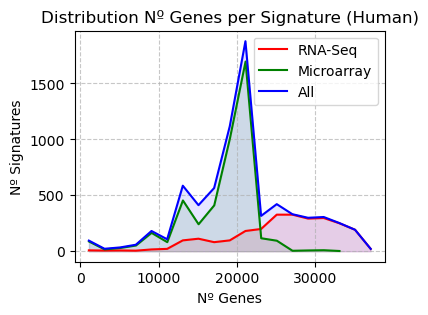

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import os  # Assuming you've already imported os for os.path.join

# Example data for demonstration, replace these with your actual datasets


plt.figure(figsize=(4, 3))


def get_counts_bins(data, bin_size=2000):
    bin_edges = np.arange(min(data), max(data) + bin_size, bin_size)
    counts, bins = np.histogram(data, bins=bin_edges)
    return counts, bins


def plot_distribution(data, label, color):
    counts, bins = get_counts_bins(data)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers, counts, label=label, linewidth=1.5, color=color)
    plt.fill_between(bin_centers, counts, alpha=0.1, color=color)


# Plotting each distribution
plot_distribution(n_genes_per_signature_RNA_Seq, "RNA-Seq", "red")
plot_distribution(n_genes_per_signature_microarray, "Microarray", "green")
plot_distribution(n_genes_per_signature_all, "All", "blue")

# Adding gridlines behind the plots
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)
plt.grid(axis="x", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.title("Distribution Nº Genes per Signature (Human)")
plt.xlabel("Nº Genes")
plt.ylabel("Nº Signatures")
plt.legend()

# Assuming 'output_path_figures' is defined earlier in your code
plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.n_genes_per_signature.png"),
    dpi=300,
    bbox_inches="tight",
)

In [4]:
n_genes_per_signature = [len(sublist) for sublist in human_dsaid_genes]
data = Counter(n_genes_per_signature)

# Prepare data for plotting
genes, values = zip(*sorted_data)  # Unzipping the sorted data into two lists
index_genes = list(range(len(genes)))

plt.figure(figsize=(4, 3))
plt.plot(index_genes, values, marker="", markersize=0, linewidth=1.5)


# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.title("Nº Genes per Signatures")
plt.xlabel("Signatures")
plt.ylabel("Nº Genes")

plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.n_signatures_per_gene.png"),
    dpi=300,
    bbox_inches="tight",
)

In [5]:
from concurrent.futures import ProcessPoolExecutor
from tqdm.contrib.concurrent import process_map  # For progress bar with process_map
import itertools

# Convert each list of gene ids to a set once
human_dsaid_genes_sets = [set(genes) for genes in human_dsaid_genes]

# Prepare all unique pairs for comparison
pairs = list(itertools.combinations(human_dsaid_genes_sets, 2))


# Function adapted for use with process_map
def compute_overlap_indices(args):
    index1, index2, human_dsaid_genes_sets = args
    gene_set_1 = human_dsaid_genes_sets[index1]
    gene_set_2 = human_dsaid_genes_sets[index2]
    intersection = len(gene_set_1.intersection(gene_set_2))
    union = len(gene_set_1.union(gene_set_2))
    overlap = intersection / union
    return overlap


# Convert each list of gene ids to a set once
human_dsaid_genes_sets = [set(genes) for genes in human_dsaid_genes]

from tqdm.contrib.concurrent import process_map

# Assuming human_dsaid_genes_sets is already defined as a list of sets
num_genes = len(human_dsaid_genes_sets)
indices_combinations = (
    (i, j, human_dsaid_genes_sets)
    for i in range(num_genes)
    for j in range(i + 1, num_genes)
)

# The function now needs to unpack the correct elements from the passed arguments,
# which includes the pair of indices to compare and the list (or list of sets) of gene IDs.
all_overlap = process_map(
    compute_overlap_indices, indices_combinations, max_workers=8, chunksize=10
)

In [76]:
def compute_overlap(gene_ids_1, gene_ids_2):
    """Compute Overlap between two lists of gene ids.
    Args:
        gene_ids_1: list
            List of gene ids
        gene_ids_2: list
            List of gene ids
    Returns:
        overlap: int
            Proportion of overlap between the two lists
    """
    overlap = len(set(gene_ids_1).intersection(set(gene_ids_2))) / len(
        set(gene_ids_1).union(set(gene_ids_2))
    )
    return overlap


all_overlap = list()
for i in tqdm(range(len(human_dsaid_genes))):
    for j in range(i + 1, len(human_dsaid_genes)):
        overlap = compute_overlap(human_dsaid_genes[i], human_dsaid_genes[j])
        all_overlap.append(overlap)

  0%|          | 8/7194 [03:16<49:03:44, 24.58s/it]


KeyboardInterrupt: 

In [ ]:
# Adding gridlines behind the bars
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=-1)

# Adding titles and labels
plt.xlabel("Organism")
plt.ylabel("Nº Signatures")
plt.title("Nº Signatures per Organism")

plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.organisms.png"),
    dpi=300,
    bbox_inches="tight",
)